# Tutorial 5: Sampling and interpolation

Today we'll be focusing on sampling continous signals and resampling a discrete ones. We will discuss the effect of sampling on the frequency domain, the aliasing artifacts that may arise and how to deal with them. Later we will understand the image processing pipeline that occures when we capture an image, with special attention given to demosaicing. Finally, we will demonstrate these topics with other imaging scenarios such as MRI.

Agenda:
- 1D and 2D sampling
- 1D and 2D aliasing artifacts
- Nyquist sampling theorem
- Image resampling
- Color filter arrays and image demosaicing
- Color corrections
- MRI sampling and aliasing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageDraw
from scipy import fftpack
import cv2
import rawpy
from scipy.ndimage import filters
import warnings
warnings.filterwarnings('ignore')

## 1D sampling 

### Example

Let's generate a bandlimited 1D singal, with its highest frequency determined by the constant `FREQ`.

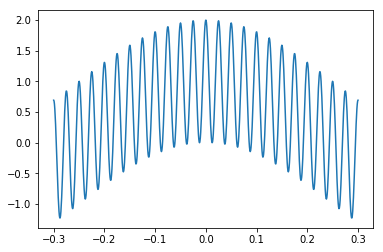

In [2]:
FREQ = 40
A = -0.3
B = 0.3
NUM_SAMPLES = 800

t = np.linspace(A, B, num=NUM_SAMPLES)
f = np.cos(2 * np.pi * t) + np.cos(2 * np.pi * FREQ * t)
plt.plot(t, f)
plt.show()

We will sample the signal with twice the speed of `FREQ`. Can we reconstruct the continuous singal?

Change the value of `RATE`. How does it affect your answer?

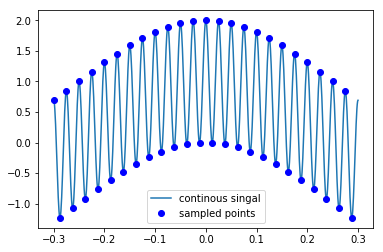

In [3]:
RATE = 1 / (2 * FREQ)

sampled_t = np.arange(A, B, step=RATE)
sampled_f = np.cos(2 * np.pi * sampled_t) + np.cos(2 * np.pi * FREQ * sampled_t)
plt.plot(t, f)
plt.plot(sampled_t, sampled_f, 'bo')
plt.legend(('continous singal', 'sampled points', ))
plt.show()

### Nyquist sampling theorem

The Nyquist sampling theorem states:
 
**"A bandlimited continuous-time signal can be sampled and perfectly reconstructed from its samples if the waveform is sampled over twice as fast as it's highest frequency component."**

We have seen it's generalized form in the lecture:

**"A $\mathcal{L}_0$-band limited singal can be perfectly reconstructed from its samples on $\mathcal{L}^\ast$."**

## 2D Sampling

### Downsampling and decimation

Let's create an image with high frequencies.

In [4]:
BASIC_ANGLE = np.pi / 4

def draw_pattern(image, num_angles=360):
    width, height = image.size
    center_x, center_y = width / 2, height / 2
    draw = PIL.ImageDraw.Draw(image)
    for angle in np.linspace(0, 2 * np.pi, num=num_angles):
        slope = np.tan(angle)
        if angle < BASIC_ANGLE:
            x = width
            y = slope * center_x + center_y
        elif angle < 3 * BASIC_ANGLE:
            x = center_y / slope + center_x
            y = height
        elif angle < 5 * BASIC_ANGLE:
            x = 0
            y = slope * center_x + center_y
        elif angle < 7 * BASIC_ANGLE:
            x = -center_y / slope + center_x
            y = 0
        else:
            x = width
            y = slope * center_x + center_y
               
        draw.line(((center_x, center_y), (round(x), round(y))))
        
SIZE = (512, 512)
BACKGROUND_COLOR = 255
NUM_ANGLES = 360

image = PIL.Image.new('L', SIZE, color=BACKGROUND_COLOR)
draw_pattern(image, NUM_ANGLES)
image.show()

Let's see what happens when we downsample it.

In [5]:
NEW_SIZE = (255, 255)

downsampled_image = image.resize(NEW_SIZE)
downsampled_image.show()

These aliasing artifacts are calleed Moiré pattern. To mitigate them, we will use some kind of low-pass filter.

In [6]:
FILTER = PIL.Image.BILINEAR

filtered_downsampled_image = image.resize(NEW_SIZE, resample=FILTER)
filtered_downsampled_image.show()

Try changing the values of `NUM_ANGLES`, `NEW_SIZE` and `FILTER` and see how they affect the resulting images.

For a complete understanding, let's display the frequency domain of each image.

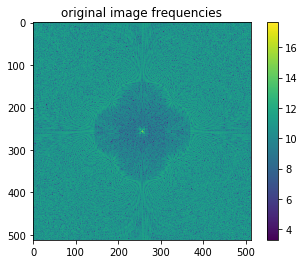

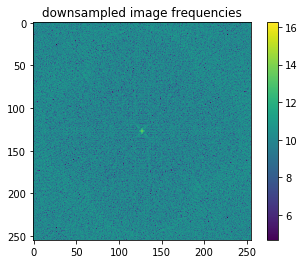

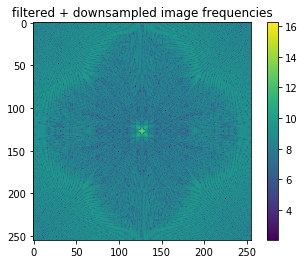

In [7]:
dft_original = fftpack.fftn(np.array(image))
plt.imshow(np.log(np.abs(fftpack.fftshift(dft_original))))
plt.title('original image frequencies')
plt.colorbar()
plt.show()

dft_downsampled = fftpack.fftn(np.array(downsampled_image))
plt.imshow(np.log(np.abs(fftpack.fftshift(dft_downsampled))))
plt.title('downsampled image frequencies')
plt.colorbar()
plt.show()

dft_downsampled_filtered = fftpack.fftn(np.array(filtered_downsampled_image))
plt.imshow(np.log(np.abs(fftpack.fftshift(dft_downsampled_filtered))))
plt.title('filtered + downsampled image frequencies')
plt.colorbar()
plt.show()

We can see that downsampling an image causes a loss of information in the frequency domain. By using an anti-aliasing filter before downsampling, we can preserve the infromation of the low frequencies.

Try examining the choice of `FILTER` on the frequency domain of the downsampled image.

### Upsampling and interpolation

Let's try to reverse the process and upsample the image with and without using a filter.

In [8]:
SIZE = (2048, 2048)
FILTER = PIL.Image.BILINEAR

upsampled_image = filtered_downsampled_image.resize(SIZE)
upsampled_image.show()

upsampled_filtered_image = filtered_downsampled_image.resize(SIZE, resample=FILTER)
upsampled_filtered_image.show()

We cannot see any difference. That's because `PIL` automatically uses the `PIL.Image.NEAREST` interpolation which determines the value of each missing pixel by one of its neighbors.

Let's check if there's any difference in the frequency domain.

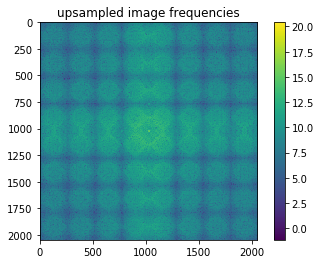

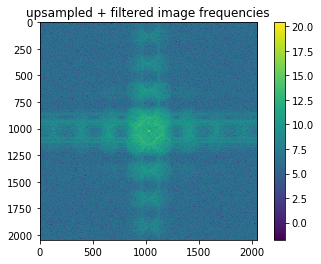

In [9]:
dft_upsampled = fftpack.fftn(np.array(upsampled_image))
plt.imshow(np.log(np.abs(fftpack.fftshift(dft_upsampled))))
plt.title('upsampled image frequencies')
plt.colorbar()
plt.show()

dft_upsampled_filtered = fftpack.fftn(np.array(upsampled_filtered_image))
plt.imshow(np.log(np.abs(fftpack.fftshift(dft_upsampled_filtered))))
plt.title('upsampled + filtered image frequencies')
plt.colorbar()
plt.show()

We can see that upsampling an image reveals false information in the high frequencies. By using a low-pass filter after upsampling, we can get rid of it.

Try examining the choice of `FILTER` on the frequency domain of the upsampled image.

### MRI

MRI samples an image in the frequency domain. Therefore we will see other kinds of artifacts when sampling.

Let's upload an MRI scan to examine.

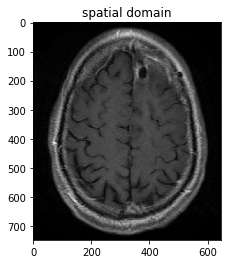

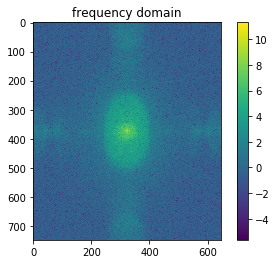

In [10]:
scan = cv2.imread('MRI-sample.png',cv2.IMREAD_GRAYSCALE).astype(float) / 255
plt.imshow(scan, cmap='gray')
plt.title('spatial domain')
plt.show()

dft_scan = fftpack.fftshift(fftpack.fftn(scan))
plt.imshow(np.log(np.abs(dft_scan)))
plt.title('frequency domain')
plt.colorbar()
plt.show()

Because of physical constraints, MRI can only sample on specific grids in the frequency domain.

Let's demonstrate sampling on equally spaced vertical lines, which is a common approach.

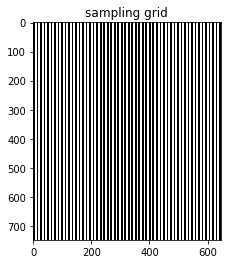

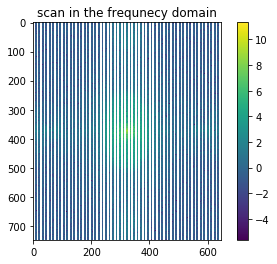

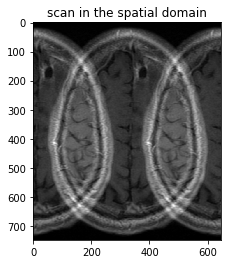

In [11]:
sampling_grid = np.ones(dft_scan.shape)
sampling_grid[:, 1::2] = 0
plt.imshow(sampling_grid, cmap='gray')
plt.title('sampling grid')
plt.show()

sampled_dft_scan = dft_scan * sampling_grid
plt.imshow(np.log(np.abs(sampled_dft_scan)))
plt.title('scan in the frequnecy domain')
plt.colorbar()
plt.show()

sampled_scan = fftpack.ifftn(fftpack.ifftshift(sampled_dft_scan))
plt.imshow(np.abs(sampled_scan), cmap='gray')
plt.title('scan in the spatial domain')
plt.show()

This artifact is common among MRI scans, and is due to the sampling-periodization duality.

### Sampling vs. quantization

In the context of images, sampling basically means how finely does our sensor sample in the spatial dimension and quantization means how sensitive our sensor is to the light. 

## ISP (Imaging Sensor Processing)

### Sensors

Two leading technologies for imaging sensors:
- CCD: Charge Coupled Device
- CMOS: Complementary Metal Oxide Semiconductors

<img src="cmos-ccd-sensors.jpg">

Let's implement a very basic ISP. We shall start by reading a raw color image as it is recordered by the camera's sensors.

Reading image raw data...
Got image with shape: (2622, 3948)


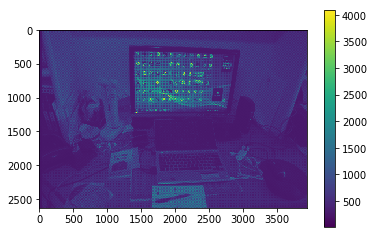

In [12]:
with rawpy.imread('scene_raw.CR2') as raw:
    print('Reading image raw data...')
    image = raw.raw_image.copy()

print(f'Got image with shape: {image.shape}')
plt.imshow(image)
plt.colorbar()
plt.show()

The image looks weired, and it only has a single channel, although we were expecting three. Let's understand why.

### Color Filter Arrays

<img src="color-filter-array.jpg">

### Demosaicing

Let's implement a basic demosaicing algorithm. We will start by separating the single channel to three different color channels: red, green and blue (RGB).

Start demosaicing:
Building channel masks...
Separating color channels...


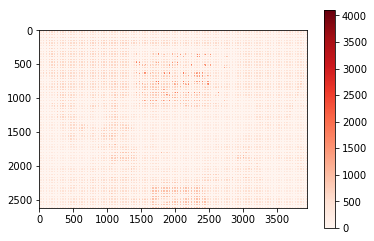

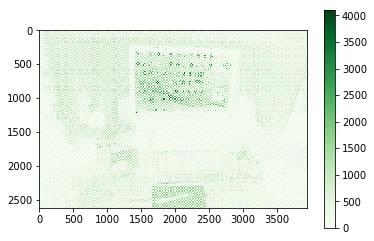

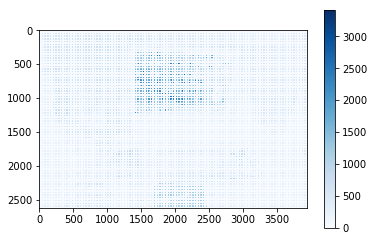

In [13]:
RED = 0
GREEN = 1
BLUE = 2

def get_cfa_channel(i, j):
    # CR2 CFA Pattern: [Red   , Green] <-- even rows: 0, 2, 4, ...
    #                  [Green , Blue]  <-- odd  rows: 1, 3, 5, ...
    if i % 2 == 0:
        return RED if j % 2 == 0 else GREEN
    else:
        return GREEN if j % 2 == 0 else BLUE
    
def get_cfa_mask(shape):
    mask = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            mask[i, j] = get_cfa_channel(i, j)
            
    return mask

print('Start demosaicing:')
print('Building channel masks...')
cfa_mask = get_cfa_mask(image.shape)
r_mask = cfa_mask == RED
g_mask = cfa_mask == GREEN
b_mask = cfa_mask == BLUE

print('Separating color channels...')
r = image * r_mask
g = image * g_mask
b = image * b_mask

plt.imshow(r, cmap='Reds')
plt.colorbar()
plt.show()

plt.imshow(g, cmap='Greens')
plt.colorbar()
plt.show()

plt.imshow(b, cmap='Blues')
plt.colorbar()
plt.show()

Let's fill in the missing values using bilinear interpolation. This is a very naive approach, as we weigh in the missing values as well, and we shouldn't expect it to give the best of results.

Running bilinear interpolation...


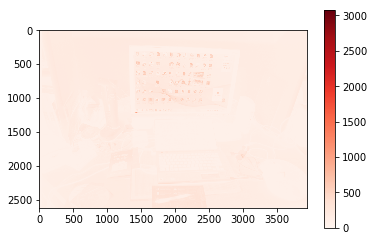

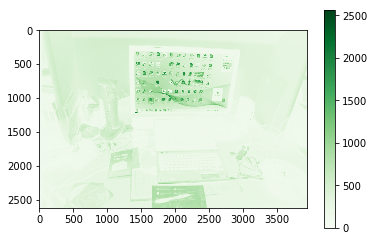

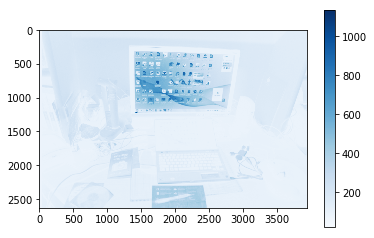

In [14]:
G_KERNEL = np.asarray(
    ((0.0, 1.0, 0.0),
     (1.0, 4.0, 1.0),
     (0.0, 1.0, 0.0))) / 8

RB_KERNEL = np.asarray(
    ((1.0, 2.0, 1.0),
     (2.0, 4.0, 2.0),
     (1.0, 2.0, 1.0))) / 12

print('Running bilinear interpolation...')
r = filters.convolve(r, RB_KERNEL)
g = filters.convolve(g, G_KERNEL)
b = filters.convolve(b, RB_KERNEL)

plt.imshow(r, cmap='Reds')
plt.colorbar()
plt.show()

plt.imshow(g, cmap='Greens')
plt.colorbar()
plt.show()

plt.imshow(b, cmap='Blues')
plt.colorbar()
plt.show()

Lastly, we will stack these three channels together into a single image.

Stacking channels...


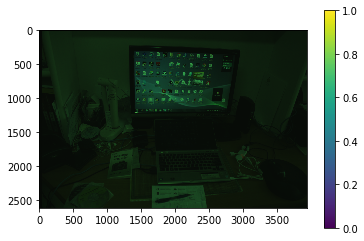

In [15]:
print('Stacking channels...')
rgb = np.dstack((r, g, b))
plt.imshow(rgb / rgb.max())
plt.colorbar()
plt.show()

### Color corrections

The image still doesn't look quite like we expect. That's because we're missing two crucial steps: black level subtraction and white balancing.

Black level subtraction...
White balancing...


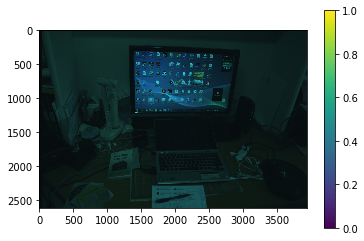

In [16]:
print('Black level subtraction...')
rgb -= np.array((r.min(), g.min(), b.min()))

print('White balancing...')
rgb = rgb / np.array((r.max() - r.min(), g.max() - g.min(), b.max() - b.min()))

plt.imshow(rgb)
plt.colorbar()
plt.show()

Again, this is a very naive approach, since we didn't used any of the camera manufacturer's statistics, nor the configured sensitivity with which the image was captured.

We will finish with gamma correction to enrich the colors.

Applying gamma encoding...


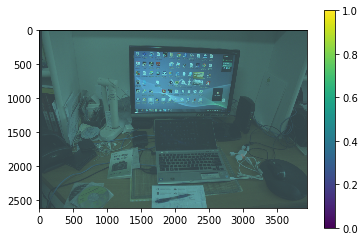

In [17]:
GAMMA = 1 / 2.2

print('Applying gamma encoding...')
rgb = rgb ** (1/2.2)

plt.imshow(rgb)
plt.colorbar()
plt.show()

Looks better! Althoguh a bit more greenish than we might have expected. This is due to our non-optimal demosaicing method, which favoured the green channel.

### Denoising

One of the most important steps of ISP is denoising. We will touch on that subject during the next few tutorials. When do you think it should be done compared to the other steps in the pipeline?

### Quanta image sensors

<img src="Quanta-Image-Sensor.png">

### DeepISP

<img src="DeepISP.png">
